In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, BasicAer, execute
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
from qiskit.quantum_info import process_fidelity
import random
import numba

%matplotlib inline

Things I need to look at:
1. Assume a function f(x) that generates the gaussian distributions (relatively well behaved). How does a strategy like this works then?
My assumption is that the more stochastic the errors are in the exploration phase, the better MAB will learn. If MAB sees more data that are not similar then it'll train better. 

2. Policy gradient 
Assume the action space is not discrete but use gradient descent to find out the best action.

3. Put error bars on that avergae plot. 
4. Time varying error. How do we balance between exploraion and exploitation. 
Use hypothesis testing. Null hypothesis is that the error does not change, alternative hypothesis is that it changes. Use how fast v0_mean_estimate or v1_mean_estimate changes to calculate some p value that will tell us that the error is changing. 
5. Optimize MAB parameters. 
6. How to extend this to more complicated error types?
7. Find composite pulses resistant against over-rotation and phase error.

In [9]:
arm=10

In [11]:
@numba.jit
def mab(mu,error,N,sigma=0.1,arm=10):  
    outcome=np.zeros((N))
    v0_angle = -np.linspace(0,1,arm)
    v1_angle = -np.linspace(0,1,arm)
    v0_mean_estimate = np.ones(arm)/arm
    v1_mean_estimate = np.ones(arm)/arm
    processfid=np.zeros((N))
    processfid_nocorrection=np.zeros((N))
    for i in range(N):
        qr_s1=QuantumRegister(1)
        qr_s2=QuantumRegister(1)
        cr_s1=ClassicalRegister(1)
        cr_s2=ClassicalRegister(1)
        specQ_s1=QuantumCircuit(qr_s1,cr_s1)
        specQ_s2=QuantumCircuit(qr_s2,cr_s2)

        specQ_s1.h(qr_s1)
        specQ_s2.h(qr_s2)

        specQ_s1.rz(error[i],qr_s1)
        specQ_s2.rz(error[i],qr_s2)

        specQ_s1.h(qr_s1)

        specQ_s1.measure(qr_s1,cr_s1)
        temp_1=execute(specQ_s1,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
        temp_2=[*temp_1.result().get_counts().keys()]
        temp_3=int(temp_2[0])
        outcome[i]=temp_3
        #contextual multi-arm bandit

        if i <= N/5:
            #uniformly explore
            if (temp_3 == 0):
                #choose action unfiformly at random
                a = random.randint(0,arm-1)

                specQ_s2.rz(v0_angle[a],qr_s2)

            elif (temp_3 == 1):
                #choose action uniformly at random
                a = random.randint(0,arm-1)
                specQ_s2.rz(v1_angle[a],qr_s2)
        else:
            # eph greedy 

            if (temp_3 == 0):
                #choose action according to eph greedy
                eph = random.randint(1,100)

                if (eph<=5):
                    a=random.randint(0,arm-1)

                    specQ_s2.rz(v0_angle[a],qr_s2)
                elif (eph>5):
                    a=np.argmax(v0_mean_estimate)

                    specQ_s2.rz(v0_angle[a],qr_s2)




            elif (temp_3 == 1):
                #choose action according to eph greedy

                eph = random.randint(1,100)

                if (eph<=5):
                    a=random.randint(0,arm-1)

                    specQ_s2.rz(v1_angle[a],qr_s2)
                elif (eph>1):
                    a=np.argmax(v1_mean_estimate)

                    specQ_s2.rz(v1_angle[a],qr_s2)


        #get reward by applying the action on s2
        #specQ_s2.sdg(qr_s2)
        specQ_s2.h(qr_s2)
        specQ_s2.measure(qr_s2,cr_s2)
        temp_4=execute(specQ_s2,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
        temp_5=[*temp_4.result().get_counts().keys()]
        temp_6=int(temp_5[0])
        #print("Second spector meas",temp_6)
        #update estimate of the arm
        if (temp_6 == 0):
            if (temp_3 ==0):
                v0_mean_estimate[a]=v0_mean_estimate[a]+0.01
            elif (temp_3 ==1):
                v0_mean_estimate[a]=v0_mean_estimate[a]-0.01
        elif (temp_6 == 1):
            if (temp_3==0):
                v1_mean_estimate[a]=v1_mean_estimate[a]+0.01
            elif (temp_3==1):
                v1_mean_estimate[a]=v1_mean_estimate[a]-0.01

        #measure the process fidelity on data
        si=np.array([[1,0],[0,1]])
        sz=np.array([[1,0],[0,-1]])
        def szerror(theta):
            return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz
        
        
        if (int(temp_3)==0):
            equiv=np.matmul(szerror(error[i]),szerror(v0_angle[a]))
            #print("A")
            processfid[i]=process_fidelity(equiv,si)
                #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
        elif (int(temp_3)==1):
            equiv=np.matmul(szerror(error[i]),szerror(v1_angle[a]))
            processfid[i]=process_fidelity(equiv,si)
            #print("B")
                #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
        processfid_nocorrection[i]=process_fidelity(szerror(error[i]),si)
            #processfid_nocorrection[i]=np.trace(np.matmul(np.transpose(szerror(error[i])),si))
    return v0_angle[np.argmax(v0_mean_estimate)], v1_angle[np.argmax(v1_mean_estimate)], processfid, processfid_nocorrection, outcome, v1_mean_estimate, v0_mean_estimate 

In [12]:
@numba.jit
def mab_mod(mu,error,N,sigma=0.1,arm=10):  
    outcome=np.zeros((N))
    v0_angle = -np.linspace(0,1,arm)
    v1_angle = -np.linspace(0,1,arm)
    v0_mean_estimate = np.ones(arm)/arm
    v1_mean_estimate = np.ones(arm)/arm
    processfid=np.zeros((N))
    processfid_nocorrection=np.zeros((N))
    for i in range(N):
        qr_s1=QuantumRegister(1)
        qr_s2=QuantumRegister(1)
        cr_s1=ClassicalRegister(1)
        cr_s2=ClassicalRegister(1)
        specQ_s1=QuantumCircuit(qr_s1,cr_s1)
        specQ_s2=QuantumCircuit(qr_s2,cr_s2)

        specQ_s1.h(qr_s1)
        specQ_s2.h(qr_s2)

        specQ_s1.rz(error[i],qr_s1)
        specQ_s2.rz(error[i],qr_s2)

        specQ_s1.h(qr_s1)

        specQ_s1.measure(qr_s1,cr_s1)
        temp_1=execute(specQ_s1,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
        temp_2=[*temp_1.result().get_counts().keys()]
        temp_3=int(temp_2[0])
        outcome[i]=temp_3

        #contextual multi-arm bandit

        if i <= N/5:
            #uniformly explore
            if (temp_3 == 0):
                #choose action unfiformly at random
                a = random.randint(0,arm-1)

                specQ_s2.rz(v0_angle[a],qr_s2)

            elif (temp_3 == 1):
                #choose action uniformly at random
                a = random.randint(0,arm-1)
                specQ_s2.rz(v1_angle[a],qr_s2)
        else:
            # eph greedy 

            if (temp_3 == 0):
                #choose action according to eph greedy
                eph = random.randint(1,100)

                if (eph<=5):
                    a=random.randint(0,arm-1)

                    specQ_s2.rz(v0_angle[a],qr_s2)
                elif (eph>5):
                    a=np.argmax(v0_mean_estimate)

                    specQ_s2.rz(v0_angle[a],qr_s2)

            elif (temp_3 == 1):
                #choose action according to eph greedy

                eph = random.randint(1,100)

                if (eph<=5):
                    a=random.randint(0,arm-1)

                    specQ_s2.rz(v1_angle[a],qr_s2)
                elif (eph>1):
                    a=np.argmax(v1_mean_estimate)

                    specQ_s2.rz(v1_angle[a],qr_s2)


        #get reward by applying the action on s2
        #specQ_s2.sdg(qr_s2)
        specQ_s2.h(qr_s2)
        specQ_s2.measure(qr_s2,cr_s2)
        temp_4=execute(specQ_s2,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
        temp_5=[*temp_4.result().get_counts().keys()]
        temp_6=int(temp_5[0])
        #print("Second spector meas",temp_6)
        #update estimate of the arm
        if (temp_6 == 0):
            if (temp_3 ==0):
                v0_mean_estimate[a]=v0_mean_estimate[a]+0.01
            elif (temp_3 ==1):
                v0_mean_estimate[a]=v0_mean_estimate[a]-0.01
        elif (temp_6 == 1):
            if (temp_3==0):
                v1_mean_estimate[a]=v1_mean_estimate[a]+0.01
            elif (temp_3==1):
                v1_mean_estimate[a]=v1_mean_estimate[a]-0.01

        #measure the process fidelity on data
        si=np.array([[1,0],[0,1]])
        sz=np.array([[1,0],[0,-1]])
        def szerror(theta):
            return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz
        
        
#         if (int(temp_3)==0):
#             equiv=np.matmul(szerror(error[i]),szerror(v0_angle[a]))
#             #print("A")
#             processfid[i]=process_fidelity(equiv,si)
#                 #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
#         elif (int(temp_3)==1):
#             equiv=np.matmul(szerror(error[i]),szerror(v1_angle[a]))
#             processfid[i]=process_fidelity(equiv,si)
#             #print("B")
#                 #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
#         processfid_nocorrection[i]=process_fidelity(szerror(error[i]),si)
            #processfid_nocorrection[i]=np.trace(np.matmul(np.transpose(szerror(error[i])),si))
    return v0_angle[np.argmax(v0_mean_estimate)], v1_angle[np.argmax(v1_mean_estimate)] ,outcome

    
        
        
    
    
    
    
    
    
    
    

In [13]:
mu_list=np.linspace(0.1,1,10)
estimates=np.zeros((len(mu_list),2))
outcome=np.zeros((len(mu_list),10000))
for i in trange(len(mu_list)):
    N=10000
    error = np.random.normal(mu_list[i],0.1,N)
    estimates[i][0],estimates[i][1], outcome[i]=mab_mod(mu_list[i],error,N) 

  0%|          | 0/10 [00:00<?, ?it/s]


UnsupportedError: Failed in object mode pipeline (step: analyzing bytecode)
[1mUse of unknown opcode 'BUILD_LIST_UNPACK'
[1m
File "<ipython-input-12-ad8aa4d4a129>", line 30:[0m
[1mdef mab_mod(mu,error,N,sigma=0.1,arm=10):  
    <source elided>
        temp_1=execute(specQ_s1,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
[1m        temp_2=[*temp_1.result().get_counts().keys()]
[0m        [1m^[0m[0m
[0m

Unsupported functionality was found in the code Numba was trying to compile.

If this functionality is important to you please file a feature request at:
https://github.com/numba/numba/issues/new


In [8]:
N=10000
error = np.random.normal(0.5,0.1,N)

In [9]:
#N=10000
#error = np.random.normal(0.8,0.1,N)
estimates_fixed=np.zeros((1,2))
processfid_av=np.zeros((N))
outcome=np.zeros((1,N))
processfid_nocorrection=np.zeros((N))
v0_mean_estimate = np.zeros(5)
v1_mean_estimate = np.zeros(5)
estimates_fixed[0][0],estimates_fixed[0][1], processfid_av, processfid_nocorrection, outcome, v0_mean_estimate, v1_mean_estimate=mab(0.8,error,N=N) 

/Users/swarnadeepmajumder/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:118: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:115: ComplexWarning: Casting complex values to real discards the imaginary part


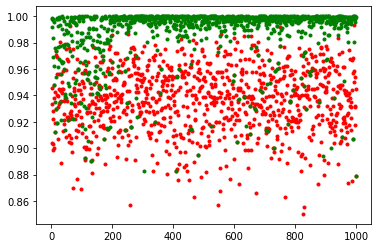

In [5]:
alpha=np.linspace(1,N,N)
plt.plot(alpha,processfid_nocorrection,'r.',alpha,processfid_av,'g.')

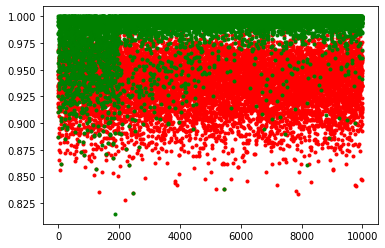

In [10]:
alpha=np.linspace(1,N,N)
plt.plot(alpha,processfid_nocorrection,'r.',alpha,processfid_av,'g.')

In [68]:
mu=0.5
sigma=0.1
arm=20
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [151]:
estimates_fixed[0][1]

-1.0

In [152]:
estimates_fixed[0][0]

-1.0

In [93]:
v1_mean_estimate

array([0.37, 6.92, 0.38, 0.41, 0.36])

In [90]:
mu=0.5
sigma=0.1
theta_0=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)-0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))
theta_1=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)+0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))

In [92]:
theta_1

-0.08880522176233986

In [58]:
v1_angle

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ])

(array([   5.,   75.,  403., 1339., 2526., 2868., 1851.,  746.,  164.,
          23.]),
 array([0.11323111, 0.18748652, 0.26174194, 0.33599735, 0.41025276,
        0.48450818, 0.55876359, 0.633019  , 0.70727442, 0.78152983,
        0.85578524]),
 <a list of 10 Patch objects>)

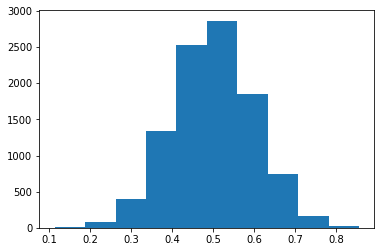

In [76]:
plt.hist(error)

In [85]:
v0_mean_estimate

array([0.106, 3.332, 0.118, 0.133, 0.114, 0.115, 0.111, 0.119, 0.116,
       0.123])

In [86]:
v1_mean_estimate

array([0.111, 1.28 , 0.107, 0.103, 0.102, 0.106, 0.111, 0.103, 0.105,
       0.103])

In [83]:
v0_angle[1]

0.14444444444444446

In [84]:
v1_angle[1]

0.5333333333333333

In [18]:
####S


def spec1qubit(theta_0,theta_1,mu,sigma=0.1,N=1000):
    error = np.random.normal(mu,sigma,N)
    #theta_0=v0_angle[np.argmax(v0_mean_estimate)]
    #theta_1=v1_angle[np.argmax(v1_mean_estimate)]
    
#     theta_0=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)-0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))
#     theta_1=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)+0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))


    theta_approx=(2/3)*alpha**2
    outcome=np.zeros((N))
    for i in range(N):
        qr=QuantumRegister(1)
        cr=ClassicalRegister(1)
        specQ=QuantumCircuit(qr,cr)
        specQ.h(qr[0])
        specQ.rz(-error[i],qr[0])
        #specQ.sdg(qr[0])
        specQ.h(qr[0])
        specQ.measure(qr[0],cr[0])
        temp_1=execute(specQ,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
        temp_2=[*temp_1.result().get_counts().keys()]
        temp_3=int(temp_2[0])
        outcome[i]=temp_3
    si=np.array([[1,0],[0,1]])
    sz=np.array([[1,0],[0,-1]])
    def szerror(theta):
        return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz
    processfid=np.zeros((N))
    processfid_nocorrection=np.zeros((N))
    processfid_avg_correction=np.zeros((N))
    for i in range(N):
        if (outcome[i]==0):
            equiv=np.matmul(szerror(error[i]),szerror(theta_0))
            processfid[i]=process_fidelity(equiv,si)
        elif (outcome[i]==1):
            equiv=np.matmul(szerror(error[i]),szerror(theta_1))
            processfid[i]=process_fidelity(equiv,si)
        processfid_nocorrection[i]=process_fidelity(szerror(error[i]),si)
        processfid_avg_correction[i]=process_fidelity(np.matmul(szerror(error[i]),szerror(-mu)),si)
    return np.mean(processfid), np.mean(processfid_nocorrection), np.mean(processfid_avg_correction)

In [19]:
n=10

alpha=np.linspace(0.1,1,n)
processfid_final=np.zeros((len(alpha)))
processfid_final_nocorrection=np.zeros((len(alpha)))
processfid_final_avg_correction=np.zeros((len(alpha)))
for i in trange(n):
    processfid_final[i],processfid_final_nocorrection[i],processfid_final_avg_correction[i] =spec1qubit(estimates[i][0],estimates[i][1],alpha[i])



  0%|          | 0/10 [00:00<?, ?it/s]/Users/swarnadeepmajumder/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


 10%|█         | 1/10 [00:05<00:52,  5.86s/it]

 20%|██        | 2/10 [00:11<00:46,  5.85s/it]

 30%|███       | 3/10 [00:17<00:40,  5.84s/it]

 40%|████      | 4/10 [00:23<00:35,  5.84s/it]

 50%|█████     | 5/10 [00:29<00:29,  5.82s/it]

 60%|█████

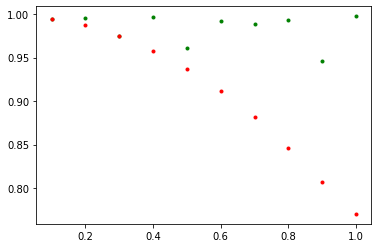

In [20]:
plt.plot(alpha,processfid_final,'g.',alpha,processfid_final_nocorrection,'r.')

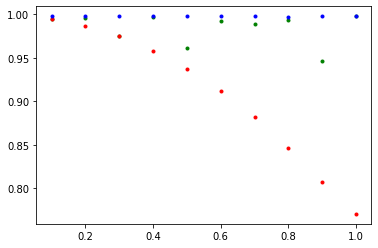

In [22]:
plt.plot(alpha,processfid_final,'g.',alpha,processfid_final_nocorrection,'r.',alpha,processfid_final_avg_correction,'b.')

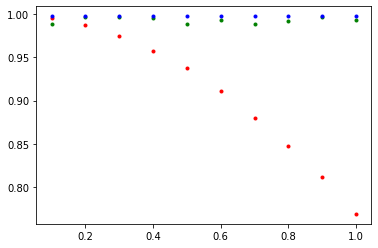

In [24]:
plt.plot(alpha,processfid_final,'g.',alpha,processfid_final_nocorrection,'r.',alpha,processfid_final_avg_correction,'b.')

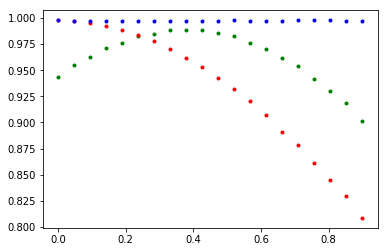

In [118]:
plt.plot(alpha,processfid_final,'g.',alpha,processfid_final_nocorrection,'r.',alpha,processfid_final_avg_correction,'b.')

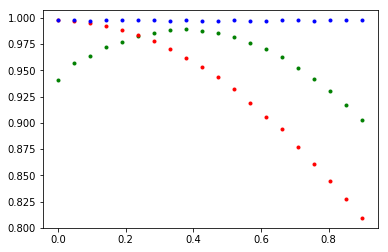

In [122]:
plt.plot(alpha,processfid_final,'g.',alpha,processfid_final_nocorrection,'r.',alpha,processfid_final_avg_correction,'b.')

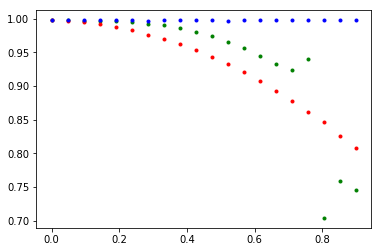

In [108]:
plt.plot(alpha,processfid_final,'g.',alpha,processfid_final_nocorrection,'r.',alpha,processfid_final_avg_correction,'b.')

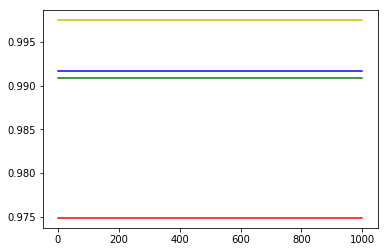

In [86]:
alpha=np.linspace(1,N,N)
plt.plot(alpha,[np.mean(processfid_av)]*len(alpha),'y',alpha,[np.mean(processfid_nocorrection)]*len(alpha),'r',alpha,[np.mean(processfid)]*len(alpha),'g',alpha,[np.mean(processfid_im)]*len(alpha),'b')

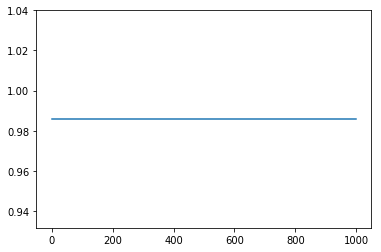

In [33]:
plt.plot([np.mean(processfid)]*len(alpha))

In [85]:
si=np.array([[1,0],[0,1]])
sz=np.array([[1,0],[0,-1]])
def szerror(theta):
    return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz
processfid=np.zeros((N))
processfid_nocorrection=np.zeros((N))
for i in range(N):
    if (outcome[i]==0):
        equiv=np.matmul(szerror(error[i]),szerror(v0_angle[np.argmax(v0_mean_estimate)]))
        processfid[i]=process_fidelity(equiv,si)
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    elif (outcome[i]==1):
        equiv=np.matmul(szerror(error[i]),szerror(v1_angle[np.argmax(v1_mean_estimate)]))
        processfid[i]=process_fidelity(equiv,si)
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    processfid_nocorrection[i]=process_fidelity(szerror(error[i]),si)
    #processfid_nocorrection[i]=np.trace(np.matmul(np.transpose(szerror(error[i])),si))
    
    

/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [100]:

mu=0
sigma=0.2
theta_0=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)-0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))
theta_1=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)+0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))

def szerror(theta):
    return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz
processfid_im=np.zeros((N))
processfid_nocorrection_im=np.zeros((N))
for i in range(N):
    if (outcome[i]==0):
        equiv=np.matmul(szerror(error[i]),szerror(theta_0))
        processfid_im[i]=process_fidelity(equiv,si)
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    elif (outcome[i]==1):
        equiv=np.matmul(szerror(error[i]),szerror(theta_1))
        processfid_im[i]=process_fidelity(equiv,si)
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    processfid_nocorrection_im[i]=process_fidelity(szerror(error[i]),si)
    #processfid_nocorrection[i]=np.trace(np.matmul(np.transpose(szerror(error[i])),si))

/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


In [101]:
mu=0
sigma=0.2
theta_0=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)-0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))
theta_1=-0.5*np.arctan((np.exp(-2*sigma**2)*np.sin(2*mu)-0.5+0.5*np.exp(-8*sigma**2)*np.cos(4*mu))/(np.exp(-2*sigma**2)*np.cos(2*mu)+0.25*np.exp(-8*sigma**2)*np.sin(4*mu)))

def szerror(theta):
    return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz
processfid_av=np.zeros((N))
#processfid_nocorrection_im=np.zeros((N))
for i in range(N):
    if (outcome[i]==0):
        equiv=np.matmul(szerror(error[i]),szerror(-mu))
        processfid_av[i]=process_fidelity(equiv,si)
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    elif (outcome[i]==1):
        equiv=np.matmul(szerror(error[i]),szerror(-mu))
        processfid_av[i]=process_fidelity(equiv,si)
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    #processfid_nocorrection_im[i]=process_fidelity(szerror(error[i]),si)
    #processfid_nocorrection[i]=np.trace(np.matmul(np.transpose(szerror(error[i])),si))

/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


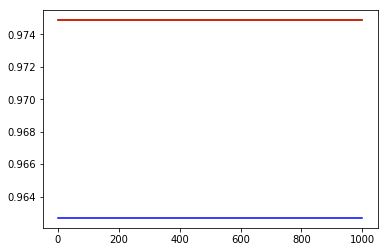

In [103]:
alpha=np.linspace(1,N,N)
plt.plot(alpha,[np.mean(processfid_av)]*len(alpha),'g',alpha,[np.mean(processfid_nocorrection)]*len(alpha),'r',alpha,[np.mean(processfid_im)]*len(alpha),'b')

In [20]:
estimates

array([[ 0.1       , -0.1       ],
       [-0.15555556, -0.35555556],
       [-0.27777778, -0.47777778],
       [-0.31111111, -0.51111111],
       [-0.3       , -0.5       ],
       [-0.46666667, -0.66666667],
       [-0.5       , -0.7       ],
       [-0.64444444, -0.84444444],
       [-0.85555556, -1.05555556],
       [-0.84444444, -1.04444444]])

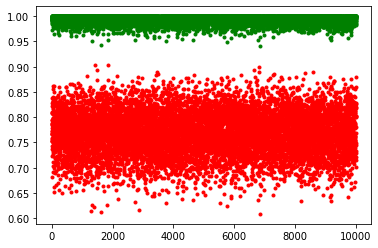

In [58]:
alpha=np.linspace(1,N,N)
plt.plot(alpha,processfid_nocorrection,'r.',alpha,processfid_av,'g.')

In [126]:
N=10000
si=np.array([[1,0],[0,1]])
sz=np.array([[1,0],[0,-1]])
def szerror(theta):
    return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz
processfid_av=np.zeros((N))
processfid_nocorrection=np.zeros((N))
for i in range(N):
    if (int(outcome[i])==0):
        equiv=np.matmul(szerror(error[i]),szerror(v0_angle[np.argmax(v0_mean_estimate)]))
        processfid_av[i]=process_fidelity(equiv,si)
        #print("A")
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    elif (int(outcome[i])==1):
        equiv=np.matmul(szerror(error[i]),szerror(v1_angle[np.argmax(v1_mean_estimate)]))
        processfid_av[i]=process_fidelity(equiv,si)
        #print("B")
        #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    processfid_nocorrection[i]=process_fidelity(szerror(error[i]),si)
    #processfid_nocorrection[i]=np.trace(np.matmul(np.transpose(szerror(error[i])),si))

/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


Building time dependent multi arm bandit. 
1. Start with mostly exploring
2. Then go to eph greedy mostly exploiting and some exploring.
3. But keep track of how much our reward estimate is chaning (some kind of a derivative).
4. If the change is above some thresold (means we need to go back to exploration).
5. Adaptive action space quantization can probably help too. 
repeat step 1

In [45]:
int(outcome[9][1])

0

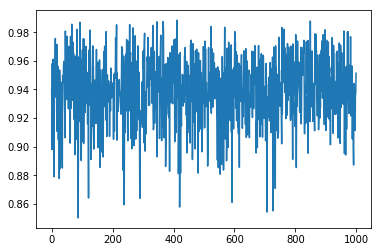

In [124]:
plt.plot(processfid_av)

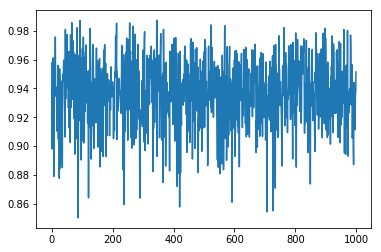

In [125]:
plt.plot(processfid_nocorrection)

In [158]:
N=10000
error = np.random.normal(0.5,0.1,N)

In [159]:
###Choosing the best arm
#N=10000
#error = np.random.normal(0.5,0.1,N)
outcome=np.zeros((N))
arm=20
v0_angle = -np.linspace(0,1,arm)
v1_angle = -np.linspace(0,1,arm)
v0_mean_estimate = np.ones(arm)/arm
v1_mean_estimate = np.ones(arm)/arm
processfid=np.zeros((N))
processfid_nocorrection=np.zeros((N))
for i in range(N):
    qr_s1=QuantumRegister(1)
    qr_s2=QuantumRegister(1)
    cr_s1=ClassicalRegister(1)
    cr_s2=ClassicalRegister(1)
    specQ_s1=QuantumCircuit(qr_s1,cr_s1)
    specQ_s2=QuantumCircuit(qr_s2,cr_s2)

    specQ_s1.h(qr_s1)
    specQ_s2.h(qr_s2)

    #specQ_data.rz(error[i],qr_data)
    specQ_s1.rz(error[i],qr_s1)
    specQ_s2.rz(error[i],qr_s2)

    #specQ_s1.sdg(qr_s1)
    specQ_s1.h(qr_s1)

    specQ_s1.measure(qr_s1,cr_s1)
    temp_1=execute(specQ_s1,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
    temp_2=[*temp_1.result().get_counts().keys()]
    temp_3=int(temp_2[0])
    outcome[i]=temp_3
    #contextual multi-arm bandit
    #print("Fisrt measurement:",temp_3)

    
    #uniformly explore
    if (temp_3 == 0):
        #choose action unfiformly at random
        a = random.randint(0,arm-1)

        specQ_s2.rz(v0_angle[a],qr_s2)

    elif (temp_3 == 1):
        #choose action uniformly at random
        a = random.randint(0,arm-1)
        specQ_s2.rz(v1_angle[a],qr_s2)
    
    #get reward by applying the action on s2
    #specQ_s2.sdg(qr_s2)
    specQ_s2.h(qr_s2)
    specQ_s2.measure(qr_s2,cr_s2)
    temp_4=execute(specQ_s2,backend=BasicAer.get_backend('qasm_simulator'),shots=1)
    temp_5=[*temp_4.result().get_counts().keys()]
    temp_6=int(temp_5[0])
    #print("Second spector meas",temp_6)
    #update estimate of the arm
    if (temp_6 == 0):
        if (temp_3 ==0):
            v0_mean_estimate[a]=v0_mean_estimate[a]+0.1
        elif (temp_3 ==1):
            v0_mean_estimate[a]=v0_mean_estimate[a]-0.1
    elif (temp_6 == 1):
        if (temp_3==0):
            v1_mean_estimate[a]=v1_mean_estimate[a]+0.1
        elif (temp_3==1):
            v1_mean_estimate[a]=v1_mean_estimate[a]-0.1

    #measure the process fidelity on data
    si=np.array([[1,0],[0,1]])
    sz=np.array([[1,0],[0,-1]])
    def szerror(theta):
        return np.cos(theta/2)*si+1.j*np.sin(theta/2)*sz


    if (int(temp_3)==0):
        equiv=np.matmul(szerror(error[i]),szerror(v0_angle[a]))
        #print("A")
        processfid[i]=process_fidelity(equiv,si)
            #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    elif (int(temp_3)==1):
        equiv=np.matmul(szerror(error[i]),szerror(v1_angle[a]))
        processfid[i]=process_fidelity(equiv,si)
        #print("B")
            #processfid[i]=np.trace(np.matmul(np.transpose(equiv),si))
    processfid_nocorrection[i]=process_fidelity(szerror(error[i]),si)
        #processfid_nocorrection[i]=np.trace(np.matmul(np.transpose(szerror(error[i])),si))



    
        
        
    
    
    
    




/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/swarnadeepmajumder/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: ComplexWarning: Casting complex values to real discards the imaginary part


In [161]:
v1_mean_estimate

array([1.75, 2.55, 1.85, 1.65, 1.15, 1.05, 0.45, 0.15, 0.25, 0.15, 0.35,
       0.45, 0.45, 0.25, 0.85, 0.95, 1.95, 2.35, 1.45, 1.95])

In [162]:
v0_angle[np.argmax(v0_mean_estimate)]

-0.5789473684210527

In [163]:
v1_angle[np.argmax(v1_mean_estimate)]

-0.05263157894736842

In [115]:
v1_mean_estimate

array([0.0502, 0.0503, 0.0502, 0.0509, 0.0506, 0.0503, 0.0505, 0.0504,
       0.0509, 0.0513, 0.0507, 0.0513, 0.0508, 0.0515, 0.051 , 0.0509,
       0.0516, 0.0526, 0.0528, 0.0518])

In [116]:
v0_mean_estimate

array([0.0537, 0.0544, 0.0537, 0.0534, 0.0531, 0.0538, 0.0535, 0.0537,
       0.0538, 0.0536, 0.0533, 0.0529, 0.0535, 0.0526, 0.0526, 0.0534,
       0.0531, 0.0523, 0.0513, 0.0519])

In [129]:
v0_angle = -np.linspace(0,0.5,2)

In [130]:
v0_angle

array([-0. , -0.5])

In [33]:
t=np.linspace(0,4*np.pi,1000)
x=np.sin(10*t)

(array([205.,  90.,  74.,  66.,  65.,  65.,  66.,  74.,  90., 205.]),
 array([-0.99999876, -0.79999901, -0.59999926, -0.39999951, -0.19999975,
         0.        ,  0.19999975,  0.39999951,  0.59999926,  0.79999901,
         0.99999876]),
 <a list of 10 Patch objects>)

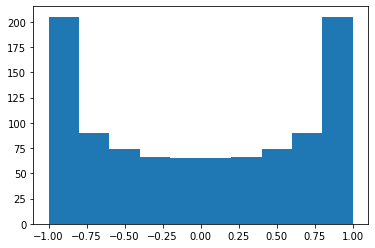

In [34]:
plt.hist(x)